In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="Y1ye8fcMOvBPYovTMA20")
project = rf.workspace("face-detection-and-recognition-dataset").project("person-faces")
version = project.version(5)
dataset = version.download("voc")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Person-Faces-5 in voc:: 100%|██████████| 6027/6027 [00:03<00:00, 1894.82it/s]


In [6]:
import cv2
import os
import xml.etree.ElementTree as ET

from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
input_dirs = ['Person-Faces-5/train',
              'Person-Faces-5/valid','Person-Faces-5/test']

# Directory to save the cropped images
output_dirs = ['dataset/train',
               'dataset/valid',
               'dataset/test']

# Create the output directories
for output_dir in output_dirs:
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

In [8]:
IMAGE_SIZE = (64, 64)

In [11]:
# Iterate over each directory
for input_dir, output_dir in zip(input_dirs, output_dirs):
    # Create the output directory for positive images
    positive_output_dir = os.path.join(output_dir, 'positive')
    if not os.path.exists(positive_output_dir):
        os.makedirs(positive_output_dir)
    
    # Create the output directory for negative images
    negative_output_dir = os.path.join(output_dir, 'negative')
    if not os.path.exists(negative_output_dir):
        os.makedirs(negative_output_dir)
    
    # Iterate over each XML file in the directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".xml"):
            # Parse the XML file
            tree = ET.parse(os.path.join(input_dir, filename))
            root = tree.getroot()

            # Read the corresponding image
            img_filename = root.find('filename').text
            img = cv2.imread(os.path.join(input_dir, img_filename))

            # Create a mask of the same size as the image, filled with ones
            mask = np.ones(img.shape[:2], dtype=bool)

            # Iterate over each 'object' element in the XML file
            for i, obj in enumerate(root.iter('object')):
                # Get the bounding box coordinates
                bndbox = obj.find('bndbox')
                x1 = int(bndbox.find('xmin').text)
                y1 = int(bndbox.find('ymin').text)
                x2 = int(bndbox.find('xmax').text)
                y2 = int(bndbox.find('ymax').text)

                # Crop and resize the object from the image
                crop_img = img[y1:y2, x1:x2]
                crop_img = cv2.resize(crop_img, IMAGE_SIZE)

                # Save the cropped image based on the object type
                output_filename = f'{img_filename.split("_jpg")[0]}-pos_{i}.jpg'
                cv2.imwrite(os.path.join(positive_output_dir, output_filename), crop_img)

            # Generate negative samples
            for i in range(len(root.findall('object'))):
                while True:
                    # Choose a random location for the crop
                    y = np.random.randint(0, img.shape[0] - IMAGE_SIZE[1])
                    x = np.random.randint(0, img.shape[1] - IMAGE_SIZE[0])

                    # If the crop does not overlap with any object, save it and break the loop
                    if mask[y:y+IMAGE_SIZE[1], x:x+IMAGE_SIZE[0]].all():
                        crop_img = img[y:y+IMAGE_SIZE[1], x:x+IMAGE_SIZE[0]]
                        crop_img = cv2.resize(crop_img, IMAGE_SIZE)
                        cv2.imwrite(os.path.join(negative_output_dir, f'{img_filename.split("_jpg")[0]}-neg_{i}.jpg'), crop_img)
                        break

In [12]:
def extract_features(images):
    features = []
    for image in images:
        image = cv2.resize(image, IMAGE_SIZE)
        # Hog features
        hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2")
        features.append(hog_features)
    return np.array(features)

In [20]:
def load_dataset(dir, images, labels, x):
    for filename in os.listdir(dir):
        image = cv2.imread(os.path.join(dir, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        image = cv2.resize(image, IMAGE_SIZE)
        images.append(image)
        labels.append(1 if x=="positive" else 0)

# load train images and labels
train_images = []
train_labels = []
load_dataset('dataset/train/positive', train_images, train_labels, "positive")
load_dataset('dataset/train/negative', train_images, train_labels, "negative")

# load valid images and labels
valid_images = []
valid_labels = []
load_dataset('dataset/valid/positive', valid_images, valid_labels, "positive")
load_dataset('dataset/valid/negative', valid_images, valid_labels, "negative")

# load test images and labels
test_images = []
test_labels = []
load_dataset('dataset/test/positive', test_images, test_labels, "positive")
load_dataset('dataset/test/negative', test_images, test_labels, "negative")

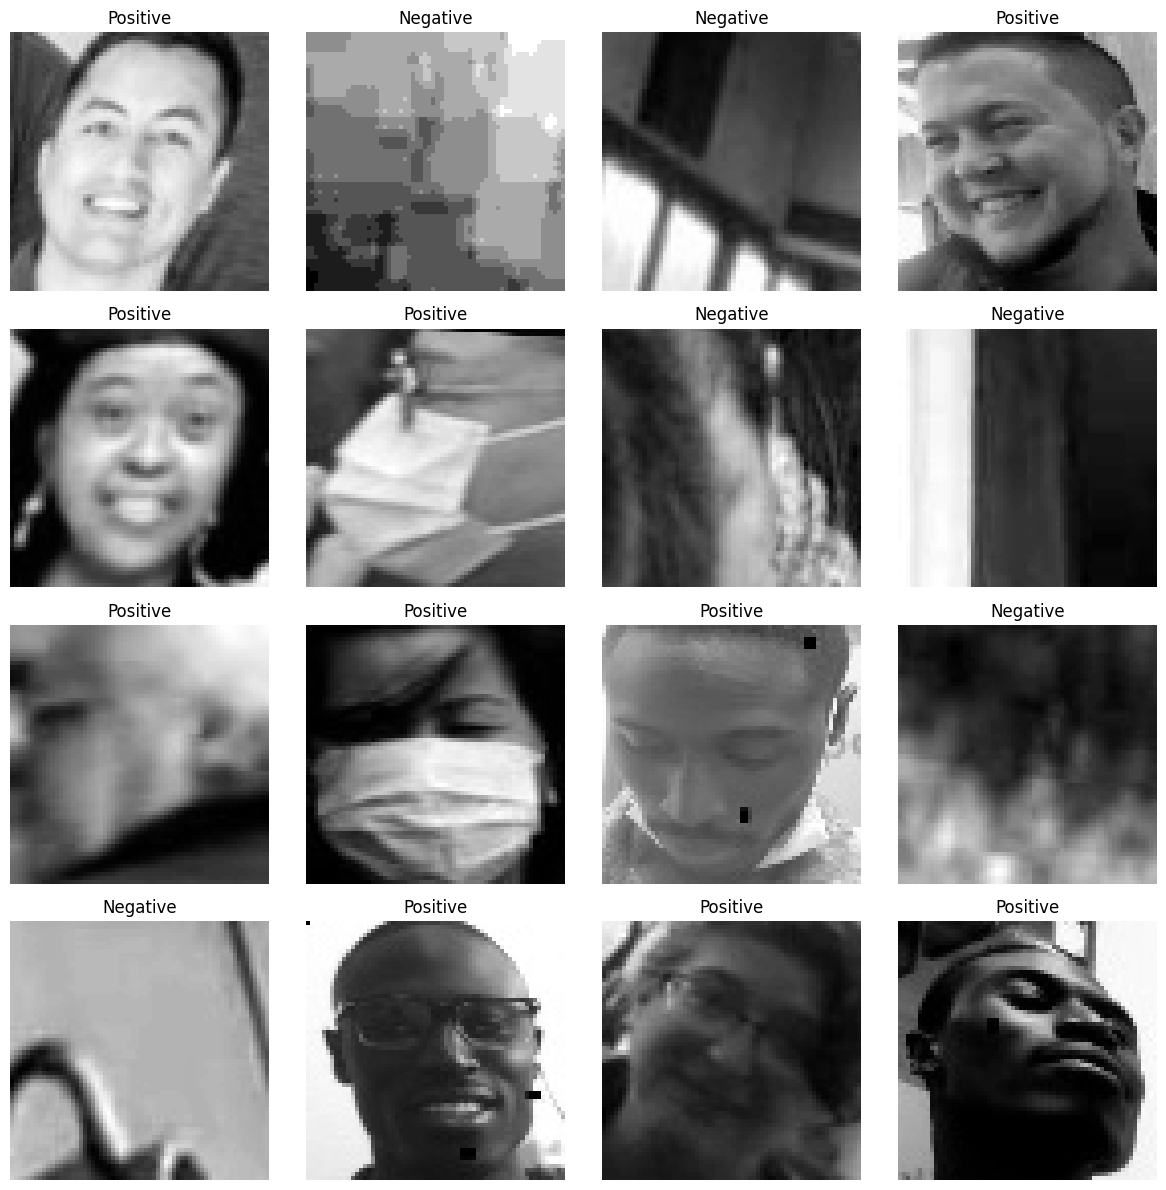

In [25]:
random_indices = np.random.choice(len(train_images), 16, replace=False).tolist()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, index in enumerate(random_indices):
    ax = axes[i // 4, i % 4]
    ax.imshow(train_images[index], cmap='gray')
    ax.axis('off')
    ax.set_title('Positive' if train_labels[index] == 1 else 'Negative')
plt.tight_layout()
plt.show()

In [26]:
# Extract HOG features
train_features = extract_features(train_images)
valid_features = extract_features(valid_images)
test_features = extract_features(test_images)

In [27]:
print(len(train_features))
print(len(valid_features))
print(len(test_features))

2272
896
926


In [34]:
# Initialize the scaler
scaler = StandardScaler()

# Combine training and validation features and labels
combined_features = np.concatenate((train_features, valid_features))
combined_labels = np.concatenate((train_labels, valid_labels))

# Fit the scaler on the training data and transform both the training and test data
combined_features_scaled = scaler.fit_transform(combined_features)

# Define the model
model = SVC(kernel='linear', probability=True, random_state=42)

# Perform 5-fold cross validation
scores = cross_val_score(model, combined_features_scaled, combined_labels, cv=5)

# Print the accuracy for each fold
for i, score in enumerate(scores, start=1):
    print(f'Accuracy for fold {i}: {score * 100:.2f}%')

# Print the mean accuracy
print(f'Mean accuracy: {scores.mean() * 100:.2f}%')

Accuracy for fold 1: 86.75%
Accuracy for fold 2: 91.32%
Accuracy for fold 3: 89.59%
Accuracy for fold 4: 88.63%
Accuracy for fold 5: 91.47%
Mean accuracy: 89.55%


In [39]:
# Fit the model on the combined training and validation data
model.fit(combined_features_scaled, combined_labels)

SVC(kernel='linear', probability=True, random_state=42)

In [53]:
time = "09-06-2024"
model_filename = f"svm_{time}.pkl"
scaler_filename = f"scaler_{time}.pkl"

In [54]:
# Export the trained model and scaler
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

In [42]:
# Load the trained model and scaler
with open(model_filename, 'rb') as file:
    model = pickle.load(file)
with open(scaler_filename, 'rb') as file:
    scaler = pickle.load(file)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       463
           1       0.92      0.90      0.91       463

    accuracy                           0.91       926
   macro avg       0.91      0.91      0.91       926
weighted avg       0.91      0.91      0.91       926



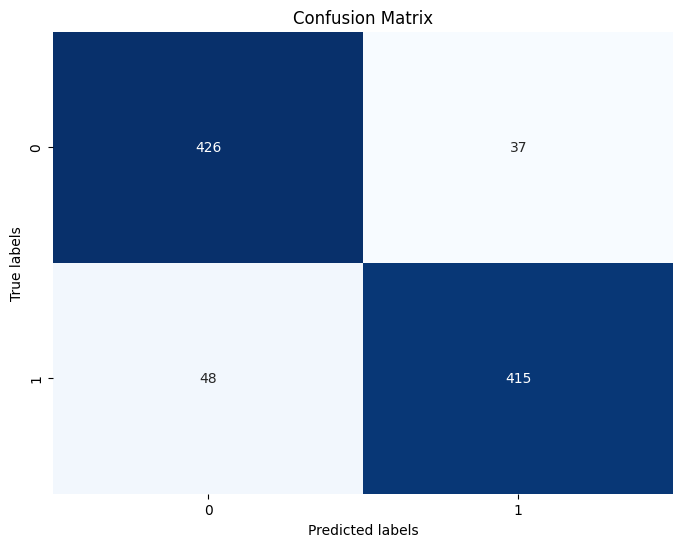

In [43]:
# Scale the test set
test_features_scaled = scaler.transform(test_features)

# Predict the labels for the test set
y_pred = model.predict(test_features_scaled)

# Print the classification report
print(classification_report(test_labels, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

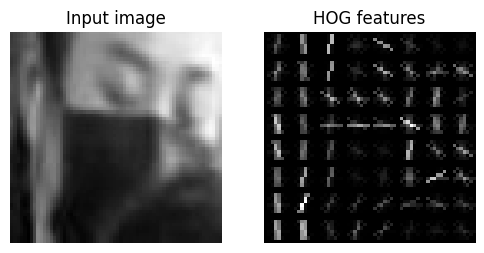

In [44]:
# visualize the HOG features
image = train_images[0]
hog_features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2", visualize=True)

fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharex=True, sharey=True)
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Input image')
axes[0].axis('off')
axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG features')
axes[1].axis('off')
plt.show()

In [51]:
custom_test_dir = r'face/'
custom_output_test_dir = r'face_output/'

custom_pos_test_dir = os.path.join(custom_output_test_dir, 'positive')
if not os.path.exists(custom_pos_test_dir):
    os.makedirs(custom_pos_test_dir)
custom_neg_test_dir = os.path.join(custom_output_test_dir, 'negative')
if not os.path.exists(custom_neg_test_dir):
    os.makedirs(custom_neg_test_dir)

# Iterate over each XML file in the directory
for filename in os.listdir(custom_test_dir):
    if filename.endswith(".xml"):
        # Parse the XML file
        tree = ET.parse(os.path.join(custom_test_dir, filename))
        root = tree.getroot()

        # Read the corresponding image
        img_filename = root.find('filename').text
        img = cv2.imread(os.path.join(custom_test_dir, img_filename))

        # Create a mask of the same size as the image, filled with ones
        mask = np.ones(img.shape[:2], dtype=bool)

        # Iterate over each 'object' element in the XML file with person as name
        for i, obj in enumerate(root.iter('object')):
            if obj.find('name').text == 'person':
                # Get the bounding box coordinates for person objects
                bndbox = obj.find('bndbox')
                x1 = int(bndbox.find('xmin').text)
                y1 = int(bndbox.find('ymin').text)
                x2 = int(bndbox.find('xmax').text)
                y2 = int(bndbox.find('ymax').text)

                # Crop and resize the object from the image
                crop_img = img[y1:y2, x1:x2]
                crop_img = cv2.resize(crop_img, IMAGE_SIZE)

                # Save the cropped image based on the object type (1 means person)
                cv2.imwrite(os.path.join(custom_pos_test_dir, f'{filename}-{i}_1.jpg'), crop_img)
            else:
                # Get the bounding box coordinates for non-person objects
                bndbox = obj.find('bndbox')
                x1 = int(bndbox.find('xmin').text)
                y1 = int(bndbox.find('ymin').text)
                x2 = int(bndbox.find('xmax').text)
                y2 = int(bndbox.find('ymax').text)

                # Crop and resize the object from the image
                crop_img = img[y1:y2, x1:x2]
                crop_img = cv2.resize(crop_img, IMAGE_SIZE)

                # Save the cropped image based on the object type (0 means non-person)
                cv2.imwrite(os.path.join(custom_neg_test_dir, f'{filename}-{i}_0.jpg'), crop_img)

                # Generate negative samples
                while True:
                    # Choose a random location for the crop
                    y = np.random.randint(0, img.shape[0] - IMAGE_SIZE[1])
                    x = np.random.randint(0, img.shape[1] - IMAGE_SIZE[0])

                    # If the crop does not overlap with any object, save it and break the loop
                    if mask[y:y+IMAGE_SIZE[1], x:x+IMAGE_SIZE[0]].all():
                        crop_img = img[y:y+IMAGE_SIZE[1], x:x+IMAGE_SIZE[0]]
                        crop_img = cv2.resize(crop_img, IMAGE_SIZE)
                        cv2.imwrite(os.path.join(custom_neg_test_dir, f'{filename}-rand-{i}_0.jpg'), crop_img)
                        break


              precision    recall  f1-score   support

           0       0.83      0.69      0.75        62
           1       0.82      0.90      0.86        93

    accuracy                           0.82       155
   macro avg       0.82      0.80      0.81       155
weighted avg       0.82      0.82      0.82       155



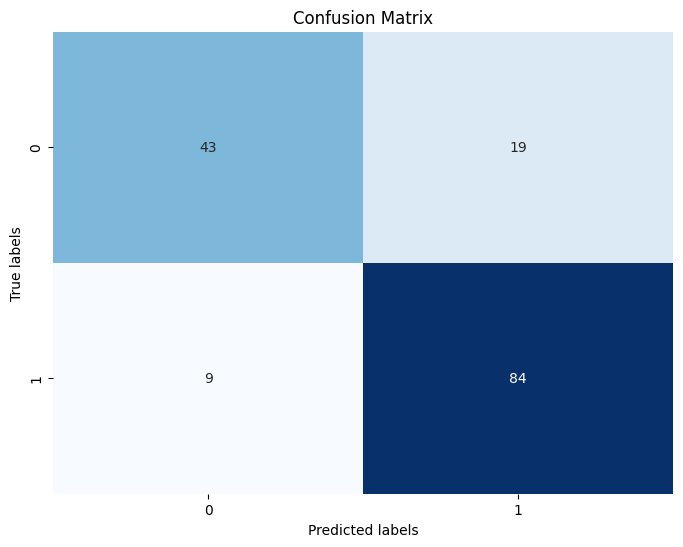

In [52]:
# load the custom test images and labels
custom_test_images = []
custom_test_labels = []

load_dataset(custom_pos_test_dir, custom_test_images, custom_test_labels, "positive")
load_dataset(custom_neg_test_dir, custom_test_images, custom_test_labels, "negative")

# Extract HOG features for custom test images
custom_test_features = extract_features(custom_test_images)

# Scale the custom test set
custom_test_features_scaled = scaler.transform(custom_test_features)

# Predict the labels for the custom test set
custom_y_pred = model.predict(custom_test_features_scaled)

# Print the classification report
print(classification_report(custom_test_labels, custom_y_pred))

# Plot the confusion matrix
cm_custom = confusion_matrix(custom_test_labels, custom_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()